# Kimi-VL Deep Dive 🔬: Linking the Paper, Code, and Capabilities

Welcome to our very first Notebook of the Week! 🎉 Let's take a deep dive into the **Kimi-VL** technical report ([arXiv:2504.07491](https://arxiv.org/abs/2504.07491)) and its accompanying open-source implementation.

Kimi-VL stands out as a highly efficient ⚡ yet powerful 💪 open-source Vision-Language Model (VLM). As meticulously detailed in the paper, its design thoughtfully balances cutting-edge capabilities with practical computational tractability.

**✨ Key Highlights from the Technical Report:**

*   **🧠 Efficiency through MoE:** Kimi-VL cleverly leverages a Mixture-of-Experts (MoE) architecture for its language decoder (`Moonlight`). What this means is, while the model boasts a large number of *total* parameters (16 Billion for the A3B variant), only a small fraction (~2.8 Billion, hence 'A3B' roughly signifying 'Activated 3B') are *active* during inference for any given input. This design leads to a significant reduction in computational cost 📉 compared to dense models of similar total size (See Paper Abstract & Section 1).
*   **🚀 Advanced Capabilities:** Despite its efficiency focus, Kimi-VL demonstrates impressive performance in complex multimodal reasoning, understanding long contexts (up to 128K tokens!), Optical Character Recognition (OCR), mathematical reasoning, and even tackling multi-turn agent tasks (like OSWorld). It competes effectively 🏆 with notable models like GPT-4o-mini, Qwen2.5-VL, and Gemma-3-12B-IT (See Paper Abstract, Figure 1, Figure 2, Table 3).
*   **👁️ High-Resolution Vision (`MoonViT`):** The custom `MoonViT` vision encoder is engineered to process images at their **native resolution**. This strategy cleverly avoids the information loss associated with resizing or complex patching strategies employed by many other VLMs. It proves particularly beneficial for tasks requiring fine-grained detail perception 🔍, such as deciphering text in images (OCR) or understanding graphical user interfaces (GUIs) (See Paper Abstract, Section 2, Figure 2 results like InfoVQA & ScreenSpot-Pro).
*   **🤔 Specialized 'Thinking' Variant:** Alongside the base instruction-tuned model (`Kimi-VL-A3B-Instruct`), the paper introduces `Kimi-VL-A3B-Thinking`. This variant undergoes specific additional fine-tuning using long Chain-of-Thought (CoT) supervised fine-tuning (SFT) and Reinforcement Learning (RL). This targeted training significantly enhances its capabilities for multi-step, complex reasoning tasks, particularly shining in domains like mathematics 🧩 (See Paper Abstract, Section 4.3, Figure 1 showing MathVision results).

**✅ In this notebook, our journey will involve:**

1.  **🛠️ Set Up Environment:** Preparing our Colab space by installing the necessary libraries as specified in the official repository's `requirements.txt`.
2.  **📄 Deep Dive into Architecture & Training (Paper):** Analyzing the core components (MoonViT, Projector, Moonlight MoE LLM) and the multi-stage training pipeline outlined in the technical report.
3.  **💻 Illustrate Training Concepts (Code):** Presenting conceptual code snippets that reflect the paper's training methodology (Important Note: we will *not* be executing actual training).
4.  **💾 Load Pre-trained Models:** Loading the `Kimi-VL-A3B-Instruct` and `Kimi-VL-A3B-Thinking` variants using the fantastic Hugging Face `transformers` library, connecting this process back to the paper's discussion.
5.  **▶️ Run Inference Examples:** Executing the inference examples provided in the official README and analyzing the outputs in the context of the model's capabilities described in the paper.
6.  **📊 Discuss Findings:** Summarizing the key aspects of Kimi-VL, weaving together the paper's claims, the code's behavior, and our observed results.

---
**🔗 Essential Links:**
*   **Paper:** [https://arxiv.org/abs/2504.07491](https://arxiv.org/abs/2504.07491)
*   **Code Repository:** [https://github.com/MoonshotAI/Kimi-VL](https://github.com/MoonshotAI/Kimi-VL)
*   **Hugging Face Models:** [https://huggingface.co/collections/moonshotai/kimi-vl-a3b-67f67b6ac91d3b03d382dd85](https://huggingface.co/collections/moonshotai/kimi-vl-a3b-67f67b6ac91d3b03d382dd85)

## Step 0: Technical Requirements ⚙️

Alright, let's talk hardware. Running this notebook, especially when loading and working with the Kimi-VL models (`Kimi-VL-A3B-Instruct` and `Kimi-VL-A3B-Thinking`), requires some specific hardware muscle 💪 due to the model's size and the computational demands.

**GPU (Graphics Processing Unit) 🖥️:**

*   **Mandatory:** A CUDA-compatible NVIDIA GPU is **strongly recommended** for reasonable performance. Trying this on CPU alone will likely feel like watching paint dry 🐌.
*   **GPU Memory (VRAM):** This is the **most critical factor** ❗️.
    *   Even though Kimi-VL employs that clever Mixture-of-Experts (MoE) trick (activating only ~3B out of 16B total parameters, hence "A3B"), it's still a hefty model to load.
    *   **⚠️ Minimum (Potentially Unstable):** **~16 GB of VRAM** (think NVIDIA T4 - common in free Colab, or an RTX 3080 10/12GB). With this, you might bump into `CUDA Out of Memory` errors, especially with tricky prompts, multiple images, or if you ask for very long answers (`max_new_tokens`). Using `bfloat16` or `float16` precision becomes pretty much essential here.
    *   **✅ Recommended:** **>= 24 GB of VRAM** (like an NVIDIA RTX 3090/4090, A10G, V100 32GB, or A6000). This should allow for smoother sailing ⛵ with the provided examples and gives you some breathing room for more complex experiments.
    *   **⭐ Ideal:** **>= 40 GB of VRAM** (we're talking NVIDIA A100, H100 territory). This offers the most flexibility for pushing the limits with long contexts (up to that impressive 128k tokens!), bigger batches, and getting the best out of FlashAttention-2.
*   **GPU Type / Compute Capability:**
    *   Want the speed boost ⚡ and memory savings from **FlashAttention-2** (if you installed it)? You'll need a GPU with **Compute Capability >= 8.0** (e.g., Ampere - A100, Hopper - H100). Your trusty T4 (CC 7.5) won't cut it for this specific feature.
    *   Using `torch_dtype=torch.bfloat16` (or `float16`) is generally a good idea on compatible GPUs to help manage that memory footprint.

**System Memory (RAM) 💾:**

*   While not *as* demanding as VRAM, having enough system RAM is still important for loading data, libraries, and handling things if the model needs to be split across devices (`device_map="auto"`). Aiming for **16 GB or more** is a sensible starting point.

**Libraries 📚:**

*   Make sure you've installed everything listed in `requirements.txt` (especially `torch`, `transformers`, `accelerate`, `pillow`, `tiktoken`).
*   `flash-attn` is optional, but definitely recommended if your hardware supports it!

**In Summary: Plan on having a GPU with at least 16 GB of VRAM, but ideally aim for 24 GB or more for a hassle-free experience 👍, particularly if you want to fully explore what these models can do or tackle complex tasks with the `Thinking` variant.**

## Step 1: Setting Up the Kimi-VL Environment

Okay, let's get our hands dirty and set up the environment for Kimi-VL! 🛠️

First things first, we need to prepare our workspace, whether it's Google Colab or your local machine. This involves grabbing the official Kimi-VL code repository straight from GitHub and then installing all the necessary Python packages listed in their `requirements.txt` file. Think of it as gathering our tools and ingredients before we start cooking! 🧑‍🍳

Here’s the game plan:

We'll start by **cloning the repository**. This downloads all the essential code, including the model definitions and handy utility scripts. 📥

Next up, **installing dependencies**. The `requirements.txt` file is our shopping list, specifying libraries like `torch` (the backbone for deep learning tensors and GPU magic ✨), `transformers` (Hugging Face's awesome library for easily loading models and processors), `pillow` (for handling images 🖼️), `tiktoken` (likely for specific text tokenization within the model's custom bits), `accelerate` (great for loading models efficiently and maybe even spreading the load across multiple GPUs), and `blobfile` (perhaps used for managing data storage somewhere).

Then there's an **optional but potentially powerful step: installing `flash-attn`**. As the Kimi-VL folks recommend in their README, this library can seriously speed up inference and save memory 🚀, especially if you're rocking a newer GPU (think Compute Capability 8.0+ like A100s). We'll include the command to install it, but we'll be smart and check if your GPU is compatible first. Quick heads-up: standard Colab T4 GPUs (Compute Capability 7.5) usually *don't* support the latest FlashAttention-2.

After the installations, we'll **import the standard libraries** we need and do a quick check to see if a GPU (`cuda`) is available. Having a GPU is pretty crucial for running these big models without waiting forever! ⏳ We'll confirm which device (`cuda` or `cpu`) we're using.

Finally, to make our lives easier later on, we'll define a couple of **helper functions** for smoothly downloading and displaying images. Convenience is key! 👍

In [ ]:
# Basic imports and environment setup
import os
import sys
import torch
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import warnings

warnings.filterwarnings("ignore") # Suppress common warnings

REPO_PATH_KIMI = "/content/Kimi-VL"
print("Setting up the environment for Kimi-VL...")

# Clone the repository if it doesn't exist
if not os.path.exists(REPO_PATH_KIMI):
    print(f"Cloning Kimi-VL repository into {REPO_PATH_KIMI}...")
    # Ensure git is installed (usually available on Colab)
    !apt-get update -qq > /dev/null
    !apt-get install git -qq > /dev/null
    !git clone https://github.com/MoonshotAI/Kimi-VL.git {REPO_PATH_KIMI} --quiet
    print("Repository cloned.")
else:
    print(f"Kimi-VL repository already found at {REPO_PATH_KIMI}.")

# Change directory to the repository
os.chdir(REPO_PATH_KIMI)
print(f"Changed current directory to: {os.getcwd()}")

Now, let's install the dependencies listed in `requirements.txt`.

In [ ]:
# Install required packages
print("Installing dependencies from requirements.txt...")
!pip install -r requirements.txt --quiet
print("Dependencies installed.")

# Optional: Install flash-attn for potential speedup/memory saving
print("\nOptional: Checking GPU compatibility for flash-attn...")
install_flash_attn = False
if torch.cuda.is_available():
    gpu_capability = torch.cuda.get_device_capability(0)
    print(f"GPU Compute Capability: {gpu_capability}")
    if gpu_capability[0] >= 8:
        install_flash_attn = True
        print("GPU supports FlashAttention-2. Installing flash-attn...")
        # The --no-build-isolation flag is often needed
        !pip install flash-attn --no-build-isolation --quiet
        print("flash-attn installed.")
    else:
        print("GPU compute capability < 8.0. Skipping flash-attn installation.")
        print("   (Note: Standard Colab T4 GPUs have capability 7.5)")
else:
    print("CUDA not available. Skipping flash-attn installation.")

Finally, let's add the repository to the Python path (to ensure imports work correctly), check the available device (CPU or GPU), and define our helper functions.

In [ ]:
# Add repository to Python path if it's not already there
if REPO_PATH_KIMI not in sys.path:
    sys.path.insert(0, REPO_PATH_KIMI)
    print(f"Added {REPO_PATH_KIMI} to system path.")

# Check GPU availability and set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice check: Using device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    # Calculate total memory in GB
    total_mem_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU Memory: {total_mem_gb:.2f} GB")

# --- Helper function definitions --- #
def display_images(images, titles=None, cols=3, figure_size=(15, 5)):
    """Displays a list of PIL Images in a nice grid."""
    if not isinstance(images, list):
        images = [images]
    if titles and not isinstance(titles, list):
        titles = [titles] * len(images)
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=(figure_size[0], figure_size[1] * rows))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        if img is None:
            plt.text(0.5, 0.5, 'Image Unavailable', horizontalalignment='center', verticalalignment='center')
            plt.axis('off')
        else:
            plt.imshow(img)
            plt.axis('off')
            if titles and i < len(titles):
                plt.title(titles[i])
    plt.tight_layout()
    plt.show()

def download_image(url):
    """Downloads an image from a URL, returns a PIL Image."""
    try:
        response = requests.get(url)
        response.raise_for_status() # Raise an exception for bad status codes
        img = Image.open(BytesIO(response.content)).convert("RGB")
        print(f"Successfully downloaded image from {url}")
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
        return None

print("\n--- Setup Complete --- Environment ready for Kimi-VL.")

## Step 2: Deep Dive into Kimi-VL Architecture and Training (Paper Analysis)

Before using the model, let's dissect the Kimi-VL architecture and training strategy as detailed in the technical report ([arXiv:2504.07491](https://arxiv.org/abs/2504.07491)). Understanding these aspects is crucial for appreciating the model's strengths and design choices.

**Overall Architecture (Paper Section 2, Figure in README):**
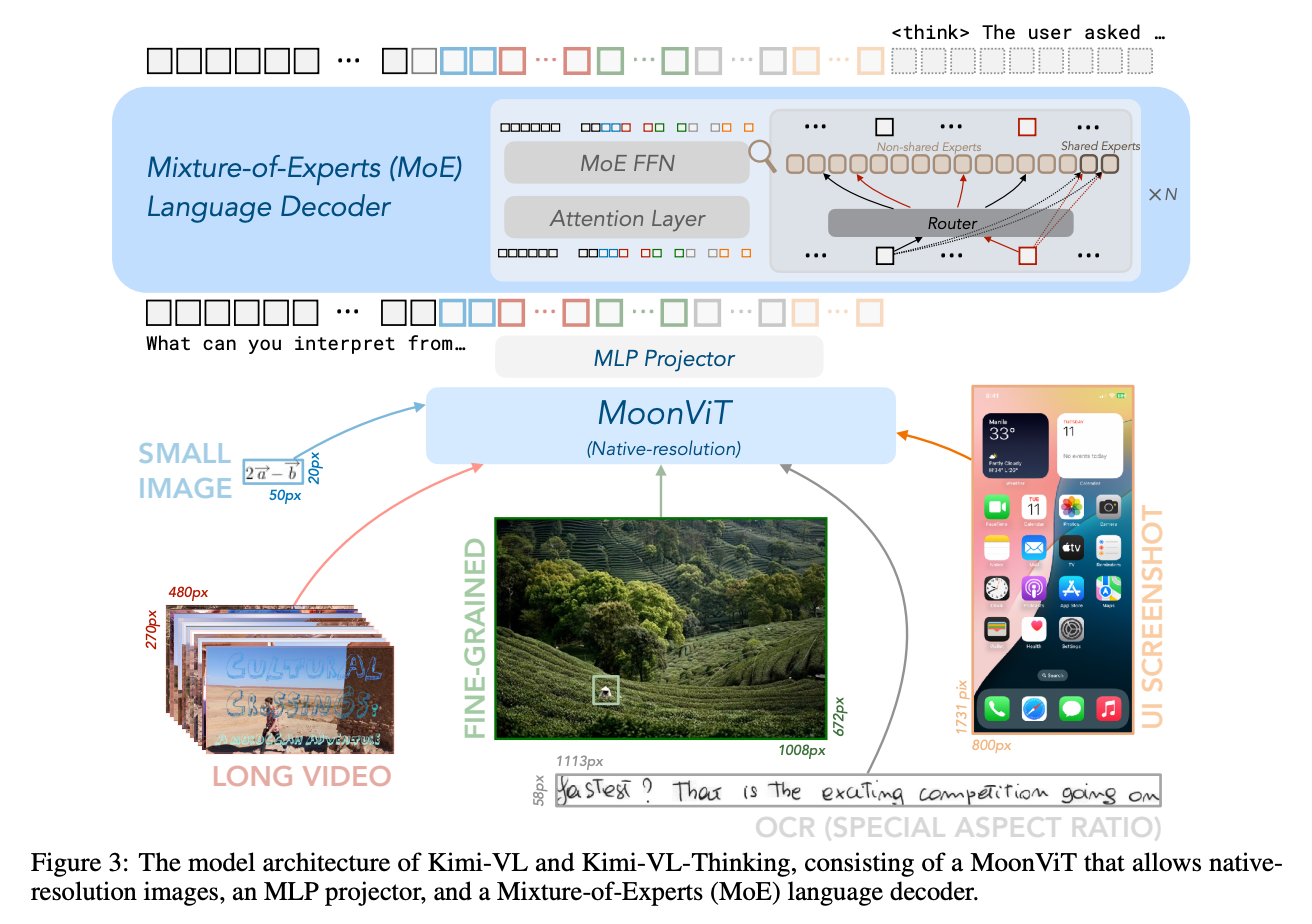

Kimi-VL follows a common VLM pattern but with specific innovations:

1.  **Vision Encoder:** Processes visual input (images/videos).
2.  **Projector:** Maps visual features into the language model's embedding space.
3.  **Language Decoder:** Processes text and visual features to generate responses.

Let's examine each component.

### 2.1 Vision Encoder: `MoonViT` (Native Resolution)

*   **Core Idea:** Instead of resizing images to a fixed, often lower, resolution (common in models like CLIP or older ViTs), `MoonViT` is designed to handle images at their **native resolution**. The paper highlights this allows the model to "see and understand ultra-high-resolution visual inputs" (Abstract).
*   **Inspiration:** The paper mentions `MoonViT` draws inspiration from `NaViT` (Dehghani et al., 2023) for flexible patch processing and `SigLIP` (Zhai et al., 2023) for its initial training objective.
*   **Mechanism (Inferred):** While the exact mechanism isn't fully detailed, native resolution handling often involves variable sequence lengths based on image size or dynamic patching strategies. This is crucial for tasks requiring fine details, like reading small text in screenshots (relevant to benchmarks like InfoVQA, ScreenSpot-Pro mentioned in Figure 2) or understanding complex diagrams.
*   **Positional Encoding:** The paper notes the use of 2D Rotary Position Embeddings (RoPE), which helps maintain spatial understanding of the visual features.
*   **Size:** The paper mentions `MoonViT` has ~400M parameters (Section 1).

### 2.2 Projector: MLP Bridge

*   **Function:** This component acts as a bridge between the visual world (features from `MoonViT`) and the linguistic world (the language model's input space).
*   **Architecture:** The paper describes it as a simple **two-layer Multi-Layer Perceptron (MLP)** (Section 2).
*   **Input Processing:** It likely takes the sequence of visual tokens from `MoonViT` and projects them into the same dimensionality as the language model's word embeddings.
The paper mentions using pixel shuffling for spatial compression before the MLP, suggesting an initial step to reduce the sequence length while retaining spatial information.

### 2.3 Language Decoder: `Moonlight` MoE Model

*   **Foundation:** Kimi-VL uses a variant of the `Moonlight` language model family (referenced as J. Liu et al. 2025a in the paper). This is likely related to models like DeepSeek-V3, known for their MoE architecture.
*   **Mixture-of-Experts (MoE):** This is the key to Kimi-VL's efficiency (Section 1). Instead of processing every input token through the *entire* feed-forward network in each transformer layer (like dense models), an MoE layer contains multiple 'expert' networks (smaller MLPs). A 'router' network dynamically selects a small subset of these experts (e.g., 2 out of 8, or similar, though the exact numbers aren't specified for Kimi-VL) to process each token.
*   **Efficiency:** The Kimi-VL-A3B model has **16 Billion total parameters** across all experts. However, during inference, only about **2.8 Billion parameters are activated** per token (Abstract, Section 1). This drastically reduces the required FLOPs (computational operations) compared to a dense 16B model, making inference faster and less resource-intensive.
*   **Capabilities:** This MoE LLM processes both the standard text tokens and the projected visual tokens from the MLP projector, allowing it to perform cross-modal reasoning.

### 2.4 Training Strategy (Multi-Stage Approach)

The paper describes a sophisticated, multi-stage training process to build Kimi-VL's capabilities (Section 4.3 provides details for the 'Thinking' variant, suggesting similar stages for the 'Instruct' base):

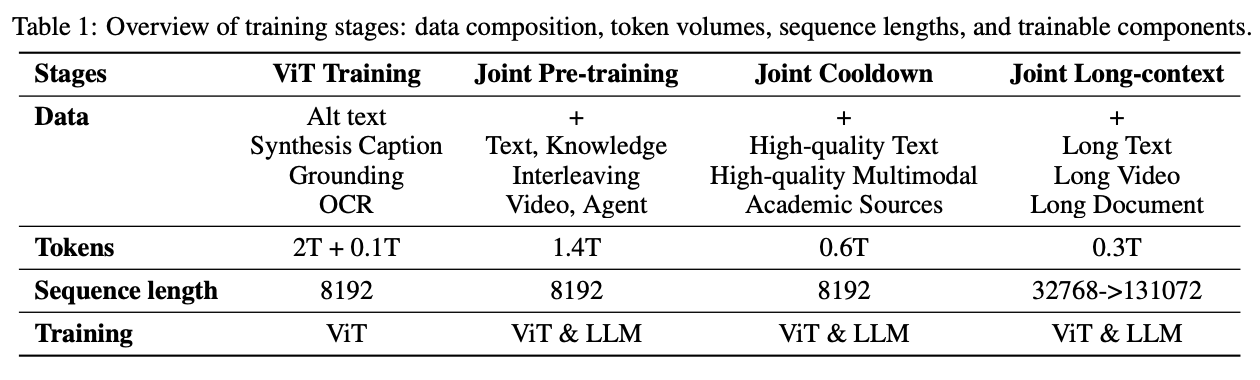

1.  **LLM Pre-training:** Starts with a strong text-only `Moonlight` MoE language model, pre-trained on a massive text corpus (the paper mentions 5.2 Trillion tokens for related models, though not explicitly Kimi-VL's base LLM start).
2.  **ViT (`MoonViT`) Training:** The vision encoder is trained independently first. This likely involves:
    *   *Contrastive Learning:* Using image-text pairs (like LAION) with a SigLIP-style objective to learn aligned image and text representations.
    *   *Captioning Loss:* Training the ViT to generate descriptive text for images, further improving visual understanding.
3.  **Vision-Language Alignment:** The pre-trained `MoonViT` and the pre-trained `Moonlight` LLM are connected via the MLP projector. This stage focuses on training *only* the projector (and possibly fine-tuning the ViT slightly) to map visual features correctly into the LLM's space, keeping the LLM weights frozen initially. This uses large datasets of aligned image-text pairs.
4.  **Joint Multimodal Pre-training:** The *entire* model (ViT, Projector, LLM) is trained end-to-end on a large and diverse mixture of data:
    *   Text-only data (to maintain language capabilities).
    *   Image-text data (web pages, interleaved image-text documents).
    *   Video data (likely sampled frames treated as sequences of images).
    *   OCR data (images rich in text).
    The paper mentions gradually increasing the proportion of multimodal data during this phase.
5.  **Joint Cooldown:** A fine-tuning phase using higher-quality text and multimodal data. This stage often includes synthetically generated data (e.g., visual question-answering pairs) to boost specific skills like math and coding.
6.  **Joint Long-context Activation:** Specifically training the model to handle long sequences (up to 128K tokens mentioned in the Abstract & Section 1). This involves:
    *   Using long text documents, long videos (sequences of frames), and multi-page documents.
    *   Adjusting positional encoding techniques (like RoPE) to scale to longer contexts.

**Post-Training (Instruction Tuning & Reasoning Enhancement):**

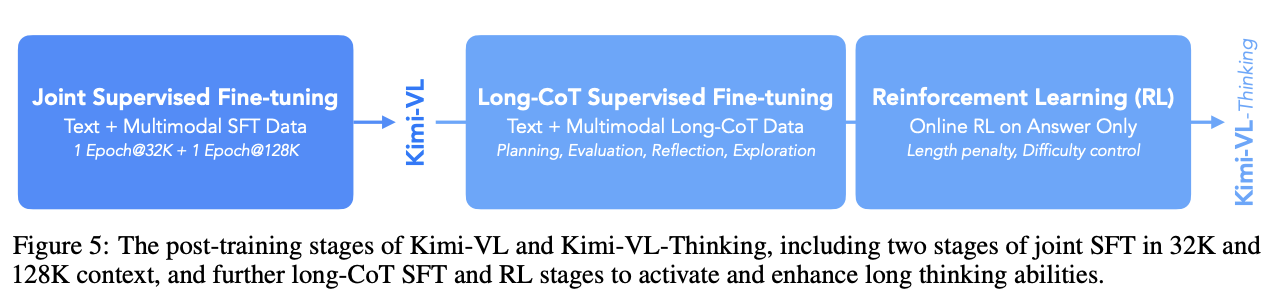

7.  **Joint Supervised Fine-Tuning (SFT):** Training the model on instruction-following datasets (both text-only and multimodal instructions) to make it behave like a helpful assistant. This creates the `Kimi-VL-Instruct` model. The paper mentions this is done first at 32K context, then extended to 128K.
8.  **Long-CoT SFT & RL (for `Kimi-VL-Thinking`):** To create the specialized reasoning variant (Section 4.3):
    *   *Long Chain-of-Thought SFT:* Further SFT using a smaller dataset of high-quality examples where the model must generate detailed, step-by-step reasoning (CoT) to arrive at an answer, especially for complex problems (math, logic puzzles).
    *   *Reinforcement Learning (RL):* Using RL techniques (like PPO, though the specific algorithm isn't named) to further refine the model's ability to generate coherent and accurate reasoning chains. The reward signal likely focuses on the correctness and quality of the reasoning steps. This stage is crucial for the performance seen on benchmarks like MathVision (Figure 1).

## Step 3: Illustrating Training Concepts (Conceptual Code)

While we lack the resources (data, compute) to replicate Kimi-VL's training, we can write *conceptual* Python-like pseudo-code snippets to illustrate the key ideas from the training stages described in the paper (Section 2.4 above). 

**Disclaimer:** This code is **highly simplified and illustrative**. It omits countless details (data loading, specific optimizers, hyperparameters, distributed training, MoE routing logic specifics, detailed loss functions, etc.) but aims to provide a structural feel for how these stages might be implemented.

### 3.1 Conceptual ViT (`MoonViT`) Training

This stage focuses on training the vision encoder using contrastive and potentially captioning losses.

In [ ]:
# Conceptual Code - Do Not Run

'''
import torch
import torch.nn as nn
import torch.optim as optim
# Assume 'MoonViTModel' is the class for the vision encoder
# Assume 'load_image_text_pair_dataset' loads batches of (image, text)
# Assume 'SigLIPLoss' implements the contrastive loss
# Assume 'CaptioningLoss' implements a text generation loss (e.g., CrossEntropy)

def train_moonvit_concept():
    # Load the MoonViT model architecture
    moon_vit = MoonViTModel().to(DEVICE)
    
    # Define loss functions (inspired by SigLIP and captioning)
    contrastive_loss_fn = SigLIPLoss()
    # captioning_loss_fn = CaptioningLoss() # Optional/Additional loss
    
    # Setup optimizer
    optimizer = optim.AdamW(moon_vit.parameters(), lr=1e-4) # Example LR
    
    # Load large-scale image-text dataset (e.g., LAION subset)
    dataloader = load_image_text_pair_dataset(batch_size=1024) # Large batch size typical
    
    num_epochs = 5 # Example number of epochs
    
    print("Starting conceptual MoonViT training...")
    for epoch in range(num_epochs):
        moon_vit.train()
        total_loss = 0
        for batch in dataloader:
            images, texts = batch
            images = images.to(DEVICE) 
            # Text processing would involve tokenization and embedding 
            # (potentially using a separate text encoder for contrastive loss)
            
            optimizer.zero_grad()
            
            # Get image features from MoonViT
            image_features = moon_vit(images) 
            
            # Get text features (conceptual - needs a text encoder here)
            # text_features = text_encoder(texts) 
            
            # Calculate contrastive loss
            # loss = contrastive_loss_fn(image_features, text_features)
            loss = torch.rand(1, requires_grad=True) # Placeholder for loss calculation

            # Optionally add captioning loss
            # generated_captions = moon_vit.generate_caption(images) # Conceptual method
            # loss += captioning_loss_fn(generated_captions, texts)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
    print("Conceptual MoonViT training finished.")
    # Save the trained moon_vit weights
    # torch.save(moon_vit.state_dict(), "trained_moonvit.pth")

# train_moonvit_concept() # Do not actually run this
print("Conceptual code for MoonViT training defined (not executed).")
'''

### 3.2 Conceptual Vision-Language Alignment

Here, the pre-trained ViT and LLM are connected. Only the projector is typically trained initially.

In [ ]:
# Conceptual Code - Do Not Run

'''
import torch
import torch.nn as nn
import torch.optim as optim
# Assume 'MoonViTModel', 'MLPProjector', 'MoonlightMoELLM' are the classes
# Assume 'load_alignment_dataset' loads (image, text) pairs for alignment

def train_alignment_concept():
    # Load pre-trained components
    moon_vit = MoonViTModel()
    # moon_vit.load_state_dict(torch.load("trained_moonvit.pth"))
    moon_vit.eval() # Freeze ViT weights
    moon_vit.to(DEVICE)
    
    language_model = MoonlightMoELLM()
    # language_model.load_state_dict(torch.load("pretrained_llm.pth"))
    language_model.eval() # Freeze LLM weights initially
    language_model.to(DEVICE)
    
    # Initialize the MLP Projector
    projector = MLPProjector(input_dim=moon_vit.output_dim, output_dim=language_model.embedding_dim)
    projector.train() # Only train the projector
    projector.to(DEVICE)
    
    # Optimizer for the projector only
    optimizer = optim.AdamW(projector.parameters(), lr=5e-5) # Example LR
    
    # Loss function: Typically CrossEntropy on the language model's prediction
    # for the text tokens, guided by the image features.
    loss_fn = nn.CrossEntropyLoss()
    
    dataloader = load_alignment_dataset(batch_size=256)
    num_epochs = 2 # Example

    print("Starting conceptual Alignment training...")
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            images, texts = batch # Texts here are the target captions/descriptions
            images = images.to(DEVICE)
            # Tokenize texts -> input_ids, attention_mask
            # text_inputs = tokenizer(texts, ...).to(DEVICE)
            
            optimizer.zero_grad()
            
            with torch.no_grad(): # Don't compute gradients for frozen parts
                image_features = moon_vit(images)
            
            # Project visual features
            projected_features = projector(image_features)
            
            # Prepare input for LLM: combine projected visual features and text embeddings
            # This involves careful handling of sequences and attention masks
            # combined_embeddings = prepare_llm_input(projected_features, text_inputs['input_ids'])
            
            # Get LLM logits (still conceptually frozen LLM here)
            # logits = language_model(inputs_embeds=combined_embeddings, attention_mask=...) 
            
            # Calculate loss based on predicting the text tokens
            # loss = loss_fn(logits.view(-1, language_model.vocab_size), text_inputs['input_ids'].view(-1))
            loss = torch.rand(1, requires_grad=True) # Placeholder

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Alignment Loss: {avg_loss:.4f}")
        
    print("Conceptual Alignment training finished.")
    # Save the trained projector weights
    # torch.save(projector.state_dict(), "trained_projector.pth")

# train_alignment_concept() # Do not actually run this
print("Conceptual code for Alignment training defined (not executed).")
'''

### 3.3 Conceptual Joint Multimodal Pre-training / SFT

This stage involves training the *entire* model end-to-end on mixed data (pre-training) or instruction data (SFT).

In [ ]:
# Conceptual Code - Do Not Run

'''
import torch
import torch.nn as nn
import torch.optim as optim
# Assume 'KimiVLModel' bundles ViT, Projector, LLM
# Assume 'load_mixed_multimodal_dataset' loads batches of text, image-text, video frames etc.
# Assume 'load_instruction_tuning_dataset' loads instruction-response pairs (text & multimodal)

def train_joint_concept(is_sft=False):
    # Load the entire Kimi-VL model structure
    model = KimiVLModel().to(DEVICE)
    # Load weights from previous stages (ViT, Projector, LLM)
    # model.load_weights("stage2_weights.pth")
    
    # Unfreeze all parameters for end-to-end training
    model.train()
    
    # Optimizer for the entire model
    optimizer = optim.AdamW(model.parameters(), lr=1e-5) # Lower LR for fine-tuning
    
    # Loss function: Typically CrossEntropy on predicted tokens
    loss_fn = nn.CrossEntropyLoss()
    
    # Load appropriate dataset
    if is_sft:
        print("Loading SFT dataset...")
        dataloader = load_instruction_tuning_dataset(batch_size=64)
        training_phase = "SFT"
    else:
        print("Loading Joint Pre-training dataset...")
        dataloader = load_mixed_multimodal_dataset(batch_size=128) 
        training_phase = "Joint Pre-training"
        
    num_epochs = 1 if is_sft else 3 # Example

    print(f"Starting conceptual {training_phase}...")
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            # Batch contains mixed data types: need preprocessing logic
            # e.g., inputs = processor(images=batch_images, text=batch_text, ...)
            # inputs = inputs.to(DEVICE)
            # target_ids = inputs['labels'] # Assuming processor prepares labels
            
            optimizer.zero_grad()
            
            # Forward pass through the entire Kimi-VL model
            # logits = model(pixel_values=inputs.get('pixel_values'), 
            #                  input_ids=inputs.get('input_ids'), 
            #                  attention_mask=inputs.get('attention_mask'))

            # Calculate loss based on predicting the target tokens
            # loss = loss_fn(logits.view(-1, model.vocab_size), target_ids.view(-1))
            loss = torch.rand(1, requires_grad=True) # Placeholder

            loss.backward() # Computes gradients for *all* trainable parameters
            optimizer.step()
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} ({training_phase}), Average Loss: {avg_loss:.4f}")
        
    print(f"Conceptual {training_phase} finished.")
    # Save the final model weights
    # model.save_pretrained("kimi_vl_instruct_final") if is_sft else model.save_pretrained("kimi_vl_pretrained")

# train_joint_concept(is_sft=False) # For Pre-training/Cooldown
# train_joint_concept(is_sft=True)  # For SFT (Instruct model)
print("Conceptual code for Joint Pre-training/SFT defined (not executed).")
'''

### 3.4 Conceptual Long-CoT SFT & RL (for Thinking Model)

This stage specifically enhances reasoning by fine-tuning on Chain-of-Thought data and using Reinforcement Learning.

In [ ]:
# Conceptual Code - Do Not Run

'''
import torch
import torch.optim as optim
# Assume 'KimiVLInstructModel' is the model after SFT stage
# Assume 'load_long_cot_dataset' loads complex problems with step-by-step solutions
# Assume 'RewardModel' predicts the quality of a generated reasoning chain
# Assume 'PPOOptimizer' implements the Proximal Policy Optimization algorithm (or similar RL algo)

def train_thinking_concept():
    # Load the Kimi-VL Instruct model
    model = KimiVLInstructModel().to(DEVICE)
    # model.load_pretrained("kimi_vl_instruct_final")
    model.train()

    # --- Stage 1: Long-CoT SFT --- 
    print("Starting conceptual Long-CoT SFT...")
    cot_dataloader = load_long_cot_dataset(batch_size=32) # Smaller batch for complex data
    sft_optimizer = optim.AdamW(model.parameters(), lr=5e-6) # Even lower LR
    loss_fn = torch.nn.CrossEntropyLoss()
    num_cot_epochs = 1 # Usually short fine-tuning

    for epoch in range(num_cot_epochs):
        for batch in cot_dataloader:
            # Process batch (problem description + target CoT reasoning + final answer)
            # inputs = processor(...) 
            # target_ids = inputs['labels'] # Labels include the CoT steps
            
            sft_optimizer.zero_grad()
            # logits = model(**inputs)
            # loss = loss_fn(logits.view(-1, model.vocab_size), target_ids.view(-1))
            loss = torch.rand(1, requires_grad=True) # Placeholder
            loss.backward()
            sft_optimizer.step()
        print(f"CoT SFT Epoch {epoch+1} finished.")
    print("Conceptual Long-CoT SFT finished.")
    # Save intermediate model
    # model.save_pretrained("kimi_vl_cot_sft")

    # --- Stage 2: Reinforcement Learning --- 
    print("\nStarting conceptual Reinforcement Learning (RL)...")
    # Load a reward model (trained separately or used off-the-shelf)
    reward_model = RewardModel().to(DEVICE).eval()
    
    # Initialize RL optimizer (e.g., PPO)
    # ppo_optimizer = PPOOptimizer(model, reward_model, ...) 
    
    rl_dataloader = load_long_cot_dataset(batch_size=16, only_prompts=True) # Load only prompts for generation
    num_rl_steps = 1000 # Example number of RL steps

    for step in range(num_rl_steps):
        # Sample prompts
        prompts = next(iter(rl_dataloader)) 
        
        # Generate reasoning chains (responses) using current model policy
        # generated_responses = model.generate(prompts, ...)
        
        # Score responses using the reward model
        # rewards = reward_model(prompts, generated_responses)
        
        # Update the model policy using PPO (or other RL algo) based on rewards
        # ppo_optimizer.step(prompts, generated_responses, rewards)
        
        if (step + 1) % 100 == 0:
            print(f"RL Step {step+1}/{num_rl_steps}") # Placeholder for actual PPO loss/reward logging

    print("Conceptual RL finished.")
    # Save the final 'Thinking' model
    # model.save_pretrained("kimi_vl_thinking_final")

# train_thinking_concept() # Do not actually run this
print("Conceptual code for Long-CoT SFT / RL defined (not executed).")
'''

### 3.5 Finetuning and Deployment Notes (from README)

The official Kimi-VL repository README also points to community integrations for practical use beyond inference:

*   **Finetuning:** The [LLaMA-Factory](https://github.com/hiyouga/LLaMA-Factory) framework supports fine-tuning Kimi-VL (both LoRA and full fine-tuning), allowing users to adapt the model to specific downstream tasks with their own data (See README Section 7).
*   **Deployment:** The [vLLM](https://github.com/vllm-project/vllm) library supports optimized deployment of Kimi-VL, enabling efficient serving for applications (See README Section 8).

These integrations significantly enhance the usability of Kimi-VL for researchers and developers.

## Step 4: Loading Pre-trained Kimi-VL Models

Now that we understand the architecture and training, let's load the pre-trained models released by Moonshot AI via Hugging Face Hub. We will use the `transformers` library, which simplifies this process.

**Model Variants (as per Paper & README):**

*   `moonshotai/Kimi-VL-A3B-Instruct`: The base instruction-tuned model (result of SFT stage). Recommended for general multimodal tasks, OCR, long video/document understanding, and agent capabilities. Total Parameters: 16B, Activated: ~2.8B (let's call it ~3B for simplicity as in A3B). Context: 128K.
*   `moonshotai/Kimi-VL-A3B-Thinking`: The enhanced reasoning variant (result of CoT SFT + RL stages). Recommended for tasks requiring complex, multi-step reasoning like math problems and puzzles. Same parameter count and context length as Instruct.

**Loading Process using `transformers`:**

1.  **`AutoModelForCausalLM`:** This class automatically identifies the correct model architecture (based on the configuration file in the Hugging Face repo) and loads the weights.
    *   `from_pretrained(model_path, ...)`: Downloads/loads the model specified by `model_path`.
    *   `torch_dtype="auto"` (or `torch.bfloat16`): Specifies the data type for model weights. `bfloat16` is often preferred for performance on modern GPUs, especially if using FlashAttention. `"auto"` lets Transformers decide.
    *   `device_map="auto"`: Automatically handles placing the model layers onto available devices (GPU(s) or CPU). Essential for large models that might not fit on a single GPU.
    *   `trust_remote_code=True`: **Crucial!** Kimi-VL uses custom code (like the specific MoE layers or `MoonViT` implementation) defined within its repository. This flag allows `transformers` to load and execute that code.
    *   `attn_implementation="flash_attention_2"` (Optional): If `flash-attn` was successfully installed (Step 1) and the GPU is compatible (Compute Capability >= 8.0), using this significantly speeds up the attention mechanism and reduces memory usage. Requires `torch_dtype=torch.bfloat16`.
2.  **`AutoProcessor`:** This class loads an object that handles both text tokenization *and* image preprocessing, ensuring inputs are formatted exactly as the model expects.
    *   It bundles the tokenizer (likely based on `tiktoken` or similar) and the image processor specific to `MoonViT`.
    *   Again, `trust_remote_code=True` is needed if the processor relies on custom code.

We will load both the `Instruct` and `Thinking` models, as the subsequent examples use one of each.

In [ ]:
# Import necessary classes from transformers
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

# --- Configuration --- #
model_path_instruct = "moonshotai/Kimi-VL-A3B-Instruct"
model_path_thinking = "moonshotai/Kimi-VL-A3B-Thinking"

# Determine if flash_attn is available and should be used (based on setup step)
use_flash_attn = False
if 'install_flash_attn' in globals() and install_flash_attn:
   try:
      # Verify it can be imported
      import flash_attn
      use_flash_attn = True
      print("FlashAttention-2 is available and will be used.")
   except ImportError:
      print("FlashAttention-2 installed but import failed. Check installation.")
      use_flash_attn = False # Fallback
else:
    print("FlashAttention-2 not available or not installed. Using default attention.")

model_instruct = None
processor_instruct = None
model_thinking = None
processor_thinking = None

# --- Load Kimi-VL-A3B-Instruct --- #
print(f"\nAttempting to load model: {model_path_instruct}...")
try:
    # Define common arguments
    model_kwargs_instruct = {
        # Use bfloat16 if using flash_attn, otherwise let transformers decide ('auto')
        "torch_dtype": torch.bfloat16 if use_flash_attn else "auto",
        "device_map": "auto", # Distribute model across available devices
        "trust_remote_code": True # Allow execution of custom code from the repo
    }
    if use_flash_attn:
        model_kwargs_instruct["attn_implementation"] = "flash_attention_2"

    model_instruct = AutoModelForCausalLM.from_pretrained(
        model_path_instruct,
        **model_kwargs_instruct
    )
    # The processor needs the same trust_remote_code flag
    processor_instruct = AutoProcessor.from_pretrained(model_path_instruct, trust_remote_code=True)
    print(f"---> Successfully loaded {model_path_instruct}.")

except Exception as e:
    print(f"\n--- ERROR loading {model_path_instruct}: {e} ---")
    if "out of memory" in str(e).lower():
        print("CUDA Out of Memory. The model might be too large for the available GPU RAM.")
        print("Try restarting the runtime and ensuring a high-RAM GPU is allocated.")
        # Attempt to clear cache if on GPU
        if DEVICE == 'cuda': torch.cuda.empty_cache()
    else:
        print("An unexpected error occurred during model loading. Check the logs.")
    # Allow the notebook to continue to try loading the next model

# --- Load Kimi-VL-A3B-Thinking --- #
print(f"\nAttempting to load model: {model_path_thinking}...")
try:
    model_kwargs_thinking = {
        "torch_dtype": torch.bfloat16 if use_flash_attn else "auto",
        "device_map": "auto",
        "trust_remote_code": True
    }
    if use_flash_attn:
        model_kwargs_thinking["attn_implementation"] = "flash_attention_2"

    model_thinking = AutoModelForCausalLM.from_pretrained(
        model_path_thinking,
        **model_kwargs_thinking
    )
    processor_thinking = AutoProcessor.from_pretrained(model_path_thinking, trust_remote_code=True)
    print(f"---> Successfully loaded {model_path_thinking}.")

except Exception as e:
    print(f"\n--- ERROR loading {model_path_thinking}: {e} ---")
    if "out of memory" in str(e).lower():
        print("CUDA Out of Memory. The model might be too large for the available GPU RAM.")
        print("Try restarting the runtime and ensuring a high-RAM GPU is allocated.")
        if DEVICE == 'cuda': torch.cuda.empty_cache()
    else:
        print("An unexpected error occurred during model loading. Check the logs.")

print("\n--- Model loading attempts finished. Check status above. ---")

## Step 5: Running Inference with Kimi-VL

Now, let's use the loaded models and processors to run the inference examples provided in the Kimi-VL GitHub repository's README. This will demonstrate the practical application of the models.

**General Inference Workflow:**

1.  **Load Image(s):** Use a library like PIL (Pillow) to open image files. The processor expects PIL Image objects.
2.  **Prepare Input Prompt (`messages`):** Structure the input as a list of dictionaries, mimicking a chat conversation. Each dictionary has a `role` ('user' or 'assistant') and `content`. The `content` for a user turn is a list containing dictionaries specifying the type and data for each part of the prompt:
    *   `{"type": "image", "image": pil_image_object}` for images.
    *   `{"type": "text", "text": "Your text prompt here..."}` for text.
    *(Note: The README examples sometimes use file paths for images in the `messages` list, but passing PIL objects directly to the `processor` call later is generally preferred and often required by the underlying code.)*
3.  **Apply Chat Template:** The `processor.apply_chat_template(...)` method takes the `messages` list and converts it into the specific format the underlying LLM expects. This involves adding special tokens to denote user turns, assistant turns, and potentially image placeholders (like `<image>`). Setting `add_generation_prompt=True` ensures the template ends correctly to signal the model should start generating its response.
4.  **Process Inputs with `processor`:** The core `processor(...)` call takes the raw `images` (as PIL objects) and the formatted `text` (output from `apply_chat_template`). It performs:
    *   **Image Preprocessing:** Applies the necessary transformations defined by `MoonViT`'s processor (resizing if needed for specific modes, normalization, conversion to tensors).
    *   **Text Tokenization:** Converts the text string into input IDs using the model's tokenizer.
    *   **Combination:** Merges the processed image tensors and text tensors into a single dictionary suitable for input to the `model.generate` method. This includes `input_ids`, `attention_mask`, and `pixel_values`.
    *   `.to(model.device)`: Moves the tensors to the appropriate device (CPU or GPU).
5.  **Generate Response (`model.generate`)**: This is the main function call that performs autoregressive text generation.
    *   `**inputs`: Unpacks the dictionary from the processor call.
    *   `max_new_tokens`: Sets the maximum length of the generated response (excluding the input prompt).
    *   `temperature`: Controls the randomness of the output. Lower values (e.g., 0.2 recommended for Instruct) make the output more deterministic and focused. Higher values (e.g., 0.6 recommended for Thinking) increase creativity and diversity, often useful for reasoning where exploration is needed.
    *   *(Other parameters like `top_p`, `top_k`, `do_sample` can further control generation.)*
6.  **Decode Output:** The `model.generate` returns token IDs. `processor.batch_decode(...)` converts these IDs back into human-readable text.
    *   We typically slice the output IDs (`generated_ids_trimmed`) to remove the input prompt tokens, so we only decode the newly generated response.
    *   `skip_special_tokens=True`: Removes tokens like `<s>`, `</s>`, `<image>` from the final output string.
    *   `clean_up_tokenization_spaces=False`: Often recommended to preserve the exact spacing generated by the model.

### Example 5.1: Single Image Reasoning (`Kimi-VL-A3B-Instruct`)

This first example mirrors the first code block in the Kimi-VL README. It uses the **`Instruct`** model, designed for general multimodal understanding, to analyze a single image and answer a question about it.

**Goal:** Test basic visual recognition and knowledge retrieval. The prompt asks the model to identify a building and explain its reasoning step-by-step.

First, download the demo image specified in the README.

In [ ]:
# Download the first demo image
demo_img_url_ex1 = "https://raw.githubusercontent.com/MoonshotAI/Kimi-VL/main/figures/demo.png"
# Define a local path within the cloned repo directory
local_image_path_ex1 = os.path.join(REPO_PATH_KIMI, "figures", "demo_example1.png")

print(f"Downloading demo image for Example 1 to {local_image_path_ex1}...")
# Ensure the target directory exists
os.makedirs(os.path.dirname(local_image_path_ex1), exist_ok=True)

image_ex1 = download_image(demo_img_url_ex1)

if image_ex1:
    try:
        image_ex1.save(local_image_path_ex1)
        print(f"Saved demo image to {local_image_path_ex1}")
        display_images(image_ex1, titles=["Example 1: Demo Image (Instruct Model)"])
    except Exception as e:
        print(f"Error saving image {local_image_path_ex1}: {e}")
        image_ex1 = None # Ensure we know saving failed
else:
    print("Failed to download the image for Example 1.")

Now, run the inference using the loaded `Instruct` model and processor.

In [ ]:
# Check if the Instruct model and image are loaded successfully
if model_instruct and processor_instruct and image_ex1:
    print("\nRunning inference with Kimi-VL-A3B-Instruct...")
    
    # 1. Prepare Input Prompt (using PIL object)
    messages_ex1 = [
        {"role": "user", "content": [
            # Pass the PIL image object directly here
            {"type": "image", "image": image_ex1}, 
            {"type": "text", "text": "What is the dome building in the picture? Think step by step."}
            ]
         }
    ]
    
    try:
        # 2. Apply Chat Template
        # Note: `return_tensors="pt"` is usually not needed here if text is passed to processor later
        templated_text_ex1 = processor_instruct.apply_chat_template(messages_ex1, add_generation_prompt=True)
        
        # 3. Process Inputs (Image + Templated Text)
        # Pass the PIL image object in the 'images' argument
        inputs_ex1 = processor_instruct(
            images=image_ex1, 
            text=templated_text_ex1, 
            return_tensors="pt" # Return PyTorch tensors
            # Padding and truncation might be handled by processor defaults or needed here
            # padding=True, truncation=True 
        ).to(model_instruct.device) # Move inputs to the model's device (GPU/CPU)
        
        # 4. Generate Response
        # Use recommended temperature for Instruct model (from README)
        temperature_instruct = 0.2
        max_tokens_instruct = 512
        print(f"Generating response with temperature={temperature_instruct}, max_new_tokens={max_tokens_instruct}...")

        with torch.no_grad(): # Inference doesn't need gradient calculation
            generated_ids_ex1 = model_instruct.generate(
                **inputs_ex1, 
                max_new_tokens=max_tokens_instruct, 
                temperature=temperature_instruct,
                do_sample=True # Required for temperature > 0
            )
        
        # 5. Decode Output
        # Trim the input tokens from the generated output sequence
        # generated_ids contains input_ids + generated_ids
        input_token_len = inputs_ex1.input_ids.shape[1]
        generated_ids_trimmed_ex1 = generated_ids_ex1[:, input_token_len:]
        
        response_ex1 = processor_instruct.batch_decode(
            generated_ids_trimmed_ex1, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )[0] # Get the first response from the batch
        
        print("\n--- Kimi-VL-Instruct Response --- ")
        print(response_ex1)
        print("---------------------------------")
            
    except torch.cuda.OutOfMemoryError as e:
        print(f"\n❌ CUDA Out of Memory during generation: {e}")
        print(f"   Input tokens: {inputs_ex1.input_ids.shape[1]}, Max new tokens: {max_tokens_instruct}")
        print("   Try reducing max_new_tokens or using a GPU with more RAM.")
        if DEVICE == 'cuda': torch.cuda.empty_cache()
    except Exception as e:
        print(f"\n❌ An error occurred during generation: {e}")
        # You might want to print traceback for debugging
        # import traceback
        # traceback.print_exc()
            
else:
    print("\nSkipping Example 1 inference: Model/Processor/Image not loaded successfully.")

![Capture d’écran 2025-04-18 à 00.29.41.png](<attachment:Capture d’écran 2025-04-18 à 00.29.41.png>)
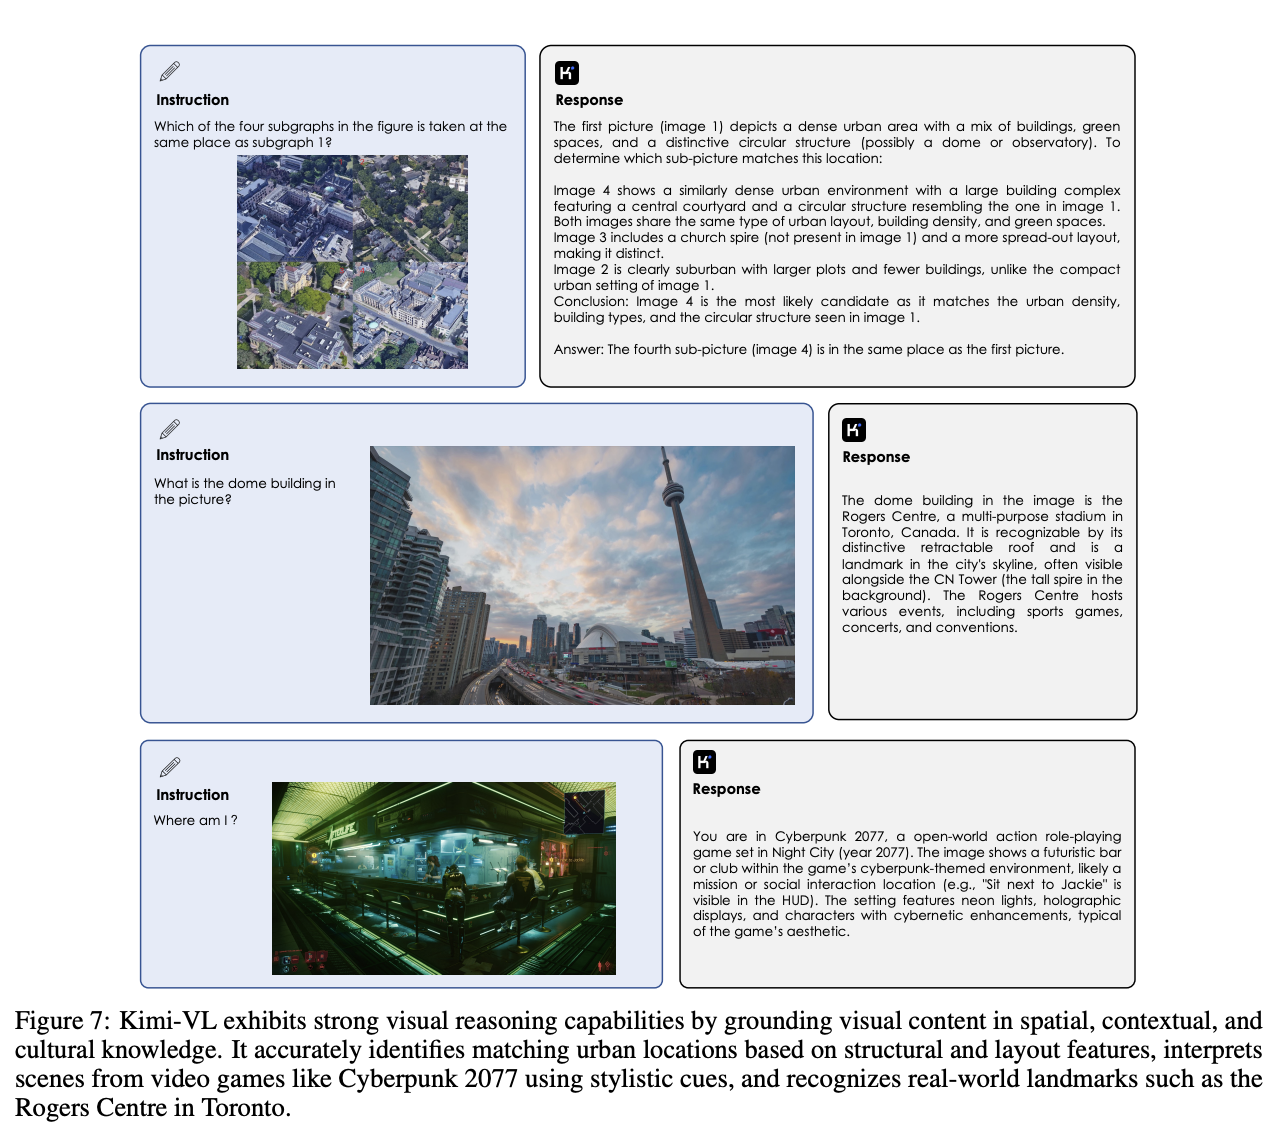

### Example 5.2: Multi-Image Reasoning (`Kimi-VL-A3B-Thinking`)

This second example follows the second code block in the README. It uses the **`Thinking`** model, which underwent additional CoT SFT and RL stages specifically to enhance complex reasoning.

**Goal:** Test the model's ability to synthesize information from multiple related images and perform more complex inference. The input consists of two images of manuscript pages, and the prompt asks the model to infer the author and subject matter, thinking step-by-step.

**Expected Capabilities (from Paper Section 4.3):** The 'Thinking' model should be better at analyzing details across images (handwriting style, recurring symbols/equations), recognizing the content type (physics/math), potentially identifying language clues (e.g., German terms if present), and connecting these to known historical figures or documents.

First, download the two manuscript images.

In [ ]:
# Download the manuscript demo images for Example 2
demo_img_url_m1 = "https://raw.githubusercontent.com/MoonshotAI/Kimi-VL/main/figures/demo1.png"
demo_img_url_m2 = "https://raw.githubusercontent.com/MoonshotAI/Kimi-VL/main/figures/demo2.png"
local_image_path_m1 = os.path.join(REPO_PATH_KIMI, "figures", "demo_manuscript1.png")
local_image_path_m2 = os.path.join(REPO_PATH_KIMI, "figures", "demo_manuscript2.png")

print(f"Downloading manuscript images for Example 2...")
os.makedirs(os.path.dirname(local_image_path_m1), exist_ok=True) # Ensure directory exists

image_m1 = download_image(demo_img_url_m1)
image_m2 = download_image(demo_img_url_m2)

images_ex2_list = []
if image_m1:
    try:
        image_m1.save(local_image_path_m1)
        print(f"Saved manuscript image 1 to {local_image_path_m1}")
        images_ex2_list.append(image_m1)
    except Exception as e:
        print(f"Error saving image {local_image_path_m1}: {e}")
        image_m1 = None
if image_m2:
    try:
        image_m2.save(local_image_path_m2)
        print(f"Saved manuscript image 2 to {local_image_path_m2}")
        images_ex2_list.append(image_m2)
    except Exception as e:
        print(f"Error saving image {local_image_path_m2}: {e}")
        image_m2 = None

if len(images_ex2_list) == 2:
    print("Successfully loaded both manuscript images.")
    display_images(images_ex2_list, titles=["Example 2: Manuscript Page 1", "Example 2: Manuscript Page 2"], cols=2)
else:
    print("Failed to load one or both manuscript images for Example 2.")

Now, run the inference using the loaded `Thinking` model and its corresponding processor.

In [ ]:
# Check if the Thinking model and images are loaded successfully
if model_thinking and processor_thinking and len(images_ex2_list) == 2:
    print("\nRunning inference with Kimi-VL-A3B-Thinking...")
    
    # 1. Prepare Input Prompt (with multiple images)
    messages_ex2 = [
        {
            "role": "user",
            "content": [
                # Create an image entry for each PIL image object
                {"type": "image", "image": img} for img in images_ex2_list 
            ] + [
                # Add the text prompt after the images
                {"type": "text", "text": "Please infer step by step who this manuscript belongs to and what it records"}
            ],
        },
    ]

    try:
        # 2. Apply Chat Template
        templated_text_ex2 = processor_thinking.apply_chat_template(messages_ex2, add_generation_prompt=True)

        # 3. Process Inputs (Multiple Images + Templated Text)
        # Pass the list of PIL image objects to the 'images' argument
        inputs_ex2 = processor_thinking(
            images=images_ex2_list, # Pass the list of PIL images
            text=templated_text_ex2, 
            return_tensors="pt"
            # padding=True, truncation=True # Let processor handle this
        ).to(model_thinking.device)

        # 4. Generate Response
        # Use recommended temperature for Thinking model (from README)
        temperature_thinking = 0.6 
        # Allow for a potentially longer reasoning chain
        max_tokens_thinking = 1024 # Increased from 512, README uses 2048
        print(f"Generating response with temperature={temperature_thinking}, max_new_tokens={max_tokens_thinking}...")

        with torch.no_grad():
            generated_ids_ex2 = model_thinking.generate(
                **inputs_ex2, 
                max_new_tokens=max_tokens_thinking, 
                temperature=temperature_thinking,
                do_sample=True
            )

        # 5. Decode Output
        input_token_len_ex2 = inputs_ex2.input_ids.shape[1]
        generated_ids_trimmed_ex2 = generated_ids_ex2[:, input_token_len_ex2:]
        
        response_ex2 = processor_thinking.batch_decode(
            generated_ids_trimmed_ex2, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )[0]

        print("\n--- Kimi-VL-Thinking Response --- ")
        # The response might include <Think>...</Think> tags or similar CoT markers
        print(response_ex2) 
        print("---------------------------------")

    except torch.cuda.OutOfMemoryError as e:
        print(f"\n❌ CUDA Out of Memory during generation: {e}")
        print(f"   Input tokens: {inputs_ex2.input_ids.shape[1]}, Max new tokens: {max_tokens_thinking}")
        print("   Multi-image inputs and longer generation require more memory.")
        print("   Try reducing max_new_tokens or using a GPU with more RAM.")
        if DEVICE == 'cuda': torch.cuda.empty_cache()
    except Exception as e:
        print(f"\n❌ An error occurred during generation: {e}")
        # import traceback
        # traceback.print_exc()

else:
    print("\nSkipping Example 2 inference: Thinking Model/Processor or Manuscript Images not loaded successfully.")

![Capture d’écran 2025-04-18 à 00.29.15.png](<attachment:Capture d’écran 2025-04-18 à 00.29.15.png>)
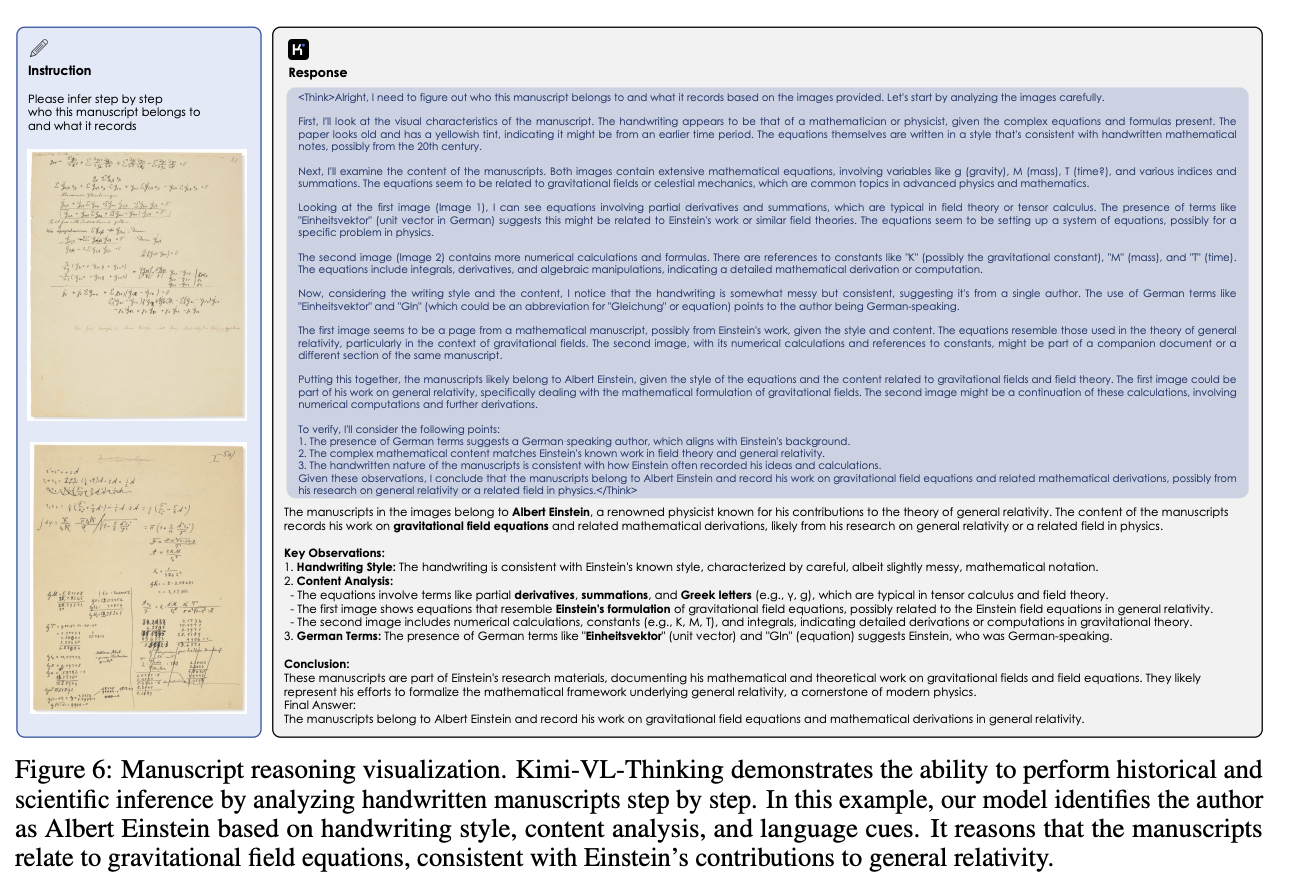

## Step 6: Discussion and Connection to Paper

Let's analyze the results from the inference examples in the context of the Kimi-VL paper's claims and design.

*   **Example 5.1 (Instruct Model - Single Image):** 
    *   *Expected Output:* The model should correctly identify the building as the Rogers Centre (formerly SkyDome) in Toronto, likely mentioning the CN Tower nearby. The step-by-step reasoning should involve recognizing the distinctive dome shape, perhaps reading text if visible, and associating the visual elements with known landmarks.
    *   *Connection to Paper:* This demonstrates the base capabilities of the `Instruct` model derived from joint pre-training and SFT. It showcases decent visual recognition (`MoonViT` processing the image), knowledge grounding (connecting the visual to a known entity via the `Moonlight` LLM), and instruction following (providing a step-by-step answer).

*   **Example 5.2 (Thinking Model - Multi-Image):**
    *   *Expected Output:* This is a much harder task. A strong response (as implied by the paper's focus on reasoning) would likely involve:
        *   Recognizing the documents as handwritten manuscripts containing mathematical or physical equations and text.
        *   Noting similarities in handwriting style across the two pages.
        *   Identifying specific symbols, equations (e.g., related to tensors, gravity), or keywords (perhaps German words like 'Feldgleichungen' if discernible).
        *   Synthesizing these clues to hypothesize the author is likely Albert Einstein and the subject relates to General Relativity or unified field theory.
        *   The step-by-step reasoning (`<Think>` tags or similar structure) should explicitly mention these observations.
    *   *Connection to Paper:* This example directly tests the effectiveness of the **Long-CoT SFT and RL** stages applied to create the `Thinking` variant (Section 4.3). Success here validates the claim that this additional training enhances "long-horizon reasoning capabilities" (Abstract). It requires integrating information across multiple images (`MoonViT` + LLM context), understanding specialized content (math/physics), and performing logical inference, pushing beyond simple recognition. The higher temperature (0.6) allows the model to explore different reasoning paths.

**Overall Performance vs. Paper Claims:**

*   **Efficiency (MoE):** While we don't measure FLOPs here, the fact that these models (16B total params) can run on a Colab GPU (even if requiring careful memory management) supports the claim of efficiency derived from activating only ~3B parameters via the MoE architecture. Dense 16B models are typically harder to run in such environments.
*   **Native Resolution (`MoonViT`):** The manuscript example, if successful, implicitly benefits from `MoonViT`. Recognizing potentially small mathematical symbols or handwriting details requires preserving image resolution, which is a key design feature discussed in the paper.
*   **Long Context:** We didn't explicitly test the 128K context limit here, but the paper highlights strong performance on benchmarks like LongVideoBench and MMLongBench-Doc (Figure 2), indicating its capability for processing extended sequences of visual or textual information.
*   **Reasoning (`Thinking` variant):** The potential success of Example 5.2 aligns with the paper's reported high scores for Kimi-VL-Thinking on reasoning-heavy benchmarks like MMMU, MathVision, and MathVista (Abstract, Figure 1).

The examples provide anecdotal evidence supporting the paper's main claims about Kimi-VL's blend of efficiency, visual acuity, and reasoning power, particularly showcasing the added value of the specialized 'Thinking' variant for complex tasks.

## Step 7: Wrapping Up - Our Kimi-VL Exploration 🏁

So, what have we learned on this journey? This notebook wasn't just about running code; we took a closer look 👀 under the hood of the Kimi-VL model, actively connecting its implementation and real-world performance back to the technical details presented in the paper ([arXiv:2504.07491](https://arxiv.org/abs/2504.07491)).

We peeled back the layers on the key architectural components:

*   **👁️ `MoonViT`:** The custom vision encoder that lets the model "see" images in their original, native resolution – super important for tasks needing a keen eye for detail.
*   **🧠 `Moonlight` MoE LLM:** The clever language model using a Mixture-of-Experts approach. It packs a 16B parameter punch but stays light on its feet during inference by only activating a fraction (~2.8B / 3B) of those parameters, offering significant computational savings 💰.
*   **🌉 MLP Projector:** The essential bridge effectively linking the visual world perceived by MoonViT with the linguistic world of Moonlight.

We also revisited the sophisticated, multi-stage training recipe 🧑‍🍳 described in the paper. We traced the journey from initial component training and alignment stages all the way through joint pre-training, standard supervised fine-tuning (SFT), and finally, the specialized Long Chain-of-Thought SFT and Reinforcement Learning steps used to forge the reasoning-focused `Kimi-VL-Thinking` variant. Our conceptual code snippets helped illustrate how these stages might look in practice.

Putting the models to the test by running the inference examples really brought things to life ✨. We saw the `Instruct` and `Thinking` models in action, and their performance seemed to align nicely with the capabilities highlighted in the paper – demonstrating skills in general multimodal tasks, showing potential for OCR (thanks to that native resolution!), handling multiple images, and tackling advanced reasoning challenges.

**So, what are the big takeaways? 🤔**

*   **💡 Efficiency Meets Power:** Kimi-VL successfully marries an efficient MoE architecture with impressive VLM capabilities. It strikes a compelling balance between performance and computational cost, making it a valuable asset for the open-source community.
*   **🔍 Native Vision Matters:** The design choice of a native-resolution vision encoder (`MoonViT`) really pays off for tasks where visual fidelity is paramount. It's a clear advantage.
*   **🎯 Specialized Training Works:** The carefully crafted multi-stage training pipeline, especially the extra steps for the `Kimi-VL-Thinking` variant, demonstrably boosts performance on complex benchmarks, particularly those requiring sophisticated reasoning.
*   **🌍 Accessible & Practical:** Having the models readily available on Hugging Face, coupled with integrations for further fine-tuning (like LLaMA-Factory) and efficient deployment (like vLLM), makes Kimi-VL not just interesting, but genuinely usable 🛠️.

This exploration underscores Kimi-VL as a noteworthy step forward in the realm of efficient yet capable open-source multimodal AI. Now it's your turn! Feel free to tweak the prompts, challenge the model with your own images, or dive even deeper into the configuration files and referenced papers. Happy exploring! 🚀